# Demo RNA Multi-Perceptrón Backpropagation usando Keras para procesar imágenes e identificar la clase que corresponde

In [1]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

import random

import cv2
from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import ipywidgets as widgets
from ipywidgets import Box, Layout
import random

print("Librerías cargadas")

Librerías cargadas


In [2]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo:

> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  476
- Ejemplo  0   (32, 32, 3) : 


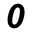



> Para Prueba: 
- Clases cargadas:  10
- Imágenes cargadas:  120
- Ejemplo  0   (32, 32, 3) : 


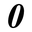

In [3]:
#@title Cargar imágenes


#@markdown ### Parámetros de imágenes:
imagen_ancho = 32 #@param {type:"integer"}
imagen_largo = 32 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}
incluir_imagenes_generadas_con_data_augmentation = False #@param {type:"boolean"}


# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))

# define tamaño de datos de entrada
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]

# indica si se usan las imágenes generadas por data augmentation
usarDA = incluir_imagenes_generadas_con_data_augmentation


# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []
  esDA_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')

            if usarDA or (not esImagDA):

                # abre la imagen
                imag = Image.open(auxiPath + "/" + each_imagFN)

                # ajusta el tamaño
                if IMAGE_SHAPE[2]==1:
                  tipoImage = 'L'
                else:
                  tipoImage = 'RGB'
                imag = imag.convert(tipoImage)
                imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

                # transforma a un vector de nros
                arImag = np.array(imag)

                # agrega a los vectores
                classes_ori.append( each_dir )
                images_ori.append( arImag )
                esDA_ori.append( esImagDA )

  return classes_ori, images_ori, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

In [4]:
#@title Ajustar imágenes para reducir el fondo (opcional)

accion_realizar = "-" #@param ["-", "Blur Fondo", "Eliminar Fondo y pasar a Negro", "Eliminar Fondo y pasar a Blanco"]

def cambiarColorNegro(img, nuevoColor=[255, 255, 255]):
    black_pixels = np.where(
        (img[:, :, 0] == 0) &
        (img[:, :, 1] == 0) &
        (img[:, :, 2] == 0)
    )
    img[black_pixels] = nuevoColor
    return img

def blurFondoImagen(im):
  # Convert to the HSV color space
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(hsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # We need a to copy the mask 3 times to fit the frames
  maskthresh = np.repeat(maskthresh[:, :, np.newaxis], 3, axis=2)
  #  Create a blurred frame using Gaussian blur
  blurred_frame = cv2.GaussianBlur(im, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  return np.where(maskthresh == (255, 255, 255), im, blurred_frame)

def reducirFondoImagen(im):
  # aplica filtro Hue
  imhsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(imhsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # aplica la máscara sobre la imagen
  imgfin = cv2.bitwise_and(im, im, mask = maskthresh)
  return imgfin

def procesarImgRedFondo(imgList):
  nList = []
  for im in imgList:
    if accion_realizar == "Blur Fondo":
      # hacer blur del fondo
      imn = blurFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Negro":
      # eliminar fondo y dejar negro
      imn = reducirFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Blanco":
        # cambia fondo negro a casi negro
        # (para que no cambié después)
        imn = cambiarColorNegro(im, [0, 0, 1])
        # eliminar fondo
        imn = reducirFondoImagen(imn)
        # cambiar fondo a blanco
        imn = cambiarColorNegro(imn, [255, 255, 255])
    else:
      print("Acción no definida!")
      break
    nList.append( imn )
  return nList


# degermina si hace algo o no
if accion_realizar != "-":
  # aplica filtros para intentar reducir el fondo de la imagen
  # cambiando las imágenes disponibles
  images_train = procesarImgRedFondo(images_train)
  images_test = procesarImgRedFondo(images_test)

  if len(classes_train)>0:
    print("- Ejemplo Entrenamiento con fondo reducido ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  if len(classes_test)>0:
    print("- Ejemplo Prueba con fondo reducido ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (476, 32, 32, 3)
 - y_trainEnc (cant):  476
 - y_train (cant):  476


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (120, 32, 32, 3)
 - y_testEnc (cant):  120
 - y_test (cant):  120


> Para Ambos: 
 - dictMapeo:  {'7': 0, '6': 1, '9': 2, '5': 3, '0': 4, '4': 5, '3': 6, '1': 7, '8': 8, '2': 9}
 - clases_map:  ['7', '6', '9', '5', '0', '4', '3', '1', '8', '2']

 - Imagen reconstruida de  0 ( 4  /  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] )


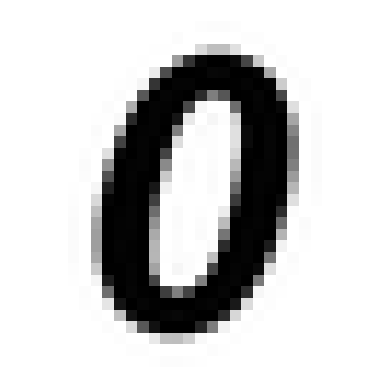

In [5]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8)) ## *255
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8)) ## *255
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
##  auxiAr = np.array(imagList).astype('float32') / 255.
##  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))
  auxiAr = np.array(imagList)
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

  return np.array(auxiAr)

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

daLayers_modelo = []

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

In [6]:
#@title Establecer capas de Image Augmentation (opcional)

aplicar_da_preProcesamiento = False #@param {type:"boolean"}

#@markdown Nota: estas capas se agregan al modelo para generar automaticamente data augmentation sólo durante el entrenamiento.
da_preProcesamiento_RandomFlip_Horizontal = False #@param {type:"boolean"}
da_preProcesamiento_RandomFlip_Vertical = False #@param {type:"boolean"}
da_preProcesamiento_RandomTranslation_Horizontal_factor = 0.2 #@param {type:"number"}
da_preProcesamiento_RandomTranslation_Vertical_factor = 0.2 #@param {type:"number"}
da_preProcesamiento_RandomRotation_factor = 0.1 #@param {type:"number"}
da_preProcesamiento_RandomZoom_factor = 0.4 #@param {type:"number"}
da_preProcesamiento_RandomContrast_factor = 0.5 #@param {type:"number"}
da_preProcesamiento_RandomBrightness_factor = 0.5 #@param {type:"number"}

daLayers_modelo = []

# capas de data augmentation (solo para training)
if aplicar_da_preProcesamiento:

  if da_preProcesamiento_RandomFlip_Horizontal or da_preProcesamiento_RandomFlip_Vertical:
    if da_preProcesamiento_RandomFlip_Horizontal:
      modeDAFlip = "horizontal"
      if da_preProcesamiento_RandomFlip_Vertical:
        modeDAFlip = modeDAFlip + "_and_vertical"
    else:
      modeDAFlip = "vertical"
    daLayers_modelo.append( tf.keras.layers.RandomFlip(mode=modeDAFlip, seed=None, name="da_rndFlip_"+modeDAFlip) )

  if (da_preProcesamiento_RandomTranslation_Horizontal_factor != 0.0) or (da_preProcesamiento_RandomTranslation_Vertical_factor != 0.0):
    daLayers_modelo.append( tf.keras.layers.RandomTranslation(height_factor=da_preProcesamiento_RandomTranslation_Vertical_factor, width_factor=da_preProcesamiento_RandomTranslation_Horizontal_factor, name="da_rndTranslation") )

  if da_preProcesamiento_RandomRotation_factor != 0.0:
      daLayers_modelo.append( tf.keras.layers.RandomRotation(factor=da_preProcesamiento_RandomRotation_factor, name="da_rndRotation") )

  if da_preProcesamiento_RandomZoom_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomZoom(height_factor=da_preProcesamiento_RandomZoom_factor, name="da_rndZoom") )

  if da_preProcesamiento_RandomContrast_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomContrast(factor=da_preProcesamiento_RandomContrast_factor, name="da_rndContrast") )

  if da_preProcesamiento_RandomBrightness_factor != 0.0:
    daLayers_modelo.append( tf.keras.layers.RandomBrightness(factor=da_preProcesamiento_RandomBrightness_factor, name="da_rndBrightness") )

# Visualize images and augmentations
cantCapasDA = len(daLayers_modelo) + 2
if cantCapasDA <= 2:
  print("No se aplican capas de Image Augmentation.")
else:
  print("Ejemplo de posibles aplicaciones:")
  fig, ax = plt.subplots(cantCapasDA, 5, figsize=(15,cantCapasDA*3))

  j = 0
  for j in range(5):

    # toma al azar las imágenes a mostrar
    posIm = random.randint(1, len(x_train))
    im = x_train[posIm-1]

    # muestra imagen original
    ax[0][j].imshow((im.astype("uint8")))
    if j == 0:
      ax[0][j].set_title("original")
    ax[0][j].axis('off')

    # muestra imagen con aplicación de capa
    i = 1
    for da_lay in daLayers_modelo:
            ax[i][j].imshow(da_lay(im).numpy().astype("uint8"))
            if j == 0:
              ax[i][j].set_title("sólo capa " + da_lay.name)
            ax[i][j].axis('off')
            i = i + 1

    # aplica todas las capas
    for da_lay in daLayers_modelo:
        im = da_lay(im)

    ax[i][j].imshow(im.numpy().astype("uint8"))
    if j == 0:
      ax[i][j].set_title("TODAS LAS CAPAS")
    ax[i][j].axis('off')

    j = j + 1

  plt.show()

No se aplican capas de Image Augmentation.


Modelo creado con  10  capas:
Model: "RNA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 32, 32, 3)]       0         
                                                                 
 slng_1/255 (Rescaling)      (None, 32, 32, 3)         0         
                                                                 
 flat (Flatten)              (None, 3072)              0         
                                                                 
 bn_1 (BatchNormalization)   (None, 3072)              12288     
                                                                 
 hidd_2 (Dense)              (None, 520)               1597960   
                                                                 
 d_3 (Dropout)               (None, 520)               0         
                                                                 
 hidd_4 (Dense)              (Non

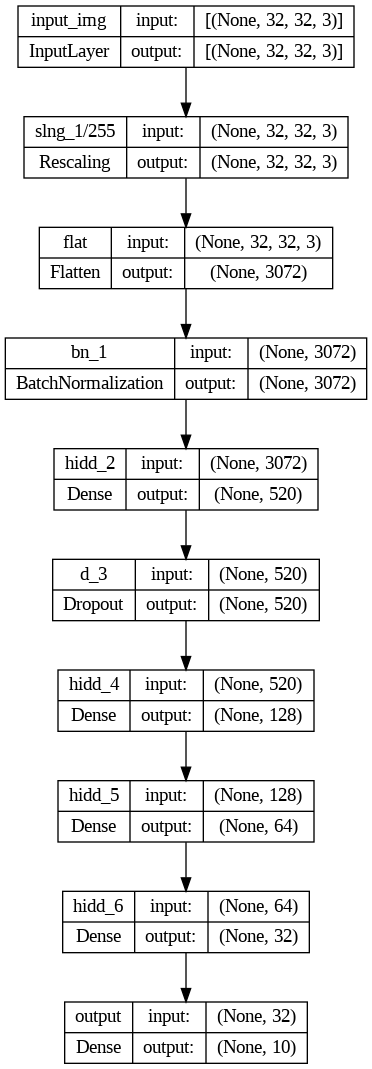

In [7]:
#@title Establecer modelo

#@markdown ### Parámetros de la Red:
rna_cant_neuronas_capas_ocultas = 'BN, 520, D, 128, 64, 32' #@param {type:"string"}
#@markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
rna_porc_capa_DropOut = 0.5 #@param {type:"number"}

rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Nadam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.005 #@param {type: "number"}

## aplicación de los parámetros elegidos

# cantidad de neuronas ocultas
##hidden_layers = [ num_inputs//5, num_inputs//20, num_inputs//100 ]
hidden_layers = []
for val in rna_cant_neuronas_capas_ocultas.split(','):
  val = val.strip()
  if val == "D":
    hidden_layers.append( "DropOut" )
  elif val == "BN":
    hidden_layers.append( "BatchNormalization" )
  elif val.isnumeric():
    hidden_layers.append( val )
  else:
    print("Capa ", val, "descartada!")

# chequea configuración de drop out
if rna_porc_capa_DropOut <= 0:
  rna_porc_capa_DropOut = 0.10
elif rna_porc_capa_DropOut > 0.9:
    rna_porc_capa_DropOut = 0.9


# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')

# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
##input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
input_img_Lay = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='input_img') # capa de entrada
eachLay = input_img_Lay

# agrega capas de data augmentation si se usan
if len(daLayers_modelo)>0:
  for da_lay in daLayers_modelo:
    eachLay = da_lay(eachLay)

# agrega capa para ajuste de imágenes
eachLay = tf.keras.layers.Rescaling(1./255, name='slng_1/255')(eachLay)
eachLay = tf.keras.layers.Flatten(name='flat')(eachLay)

# agrega capas ocultas
auxName = 'hidd_'
auxId = 1
for val_hid in hidden_layers:

  if val_hid == "DropOut":
    auxlayerName = "d_"+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dropout(rna_porc_capa_DropOut, name=auxlayerName)(eachLay)
  elif val_hid == "BatchNormalization":
    auxlayerName = "bn_"+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
  elif val_hid.isnumeric():
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = tf.keras.layers.Dense(int(val_hid), name=auxlayerName)(eachLay) # capas ocultas

# agrega capa de salida
if tipo_output_softMax:
    # se genera una capa softmax
    output_img_Lay = tf.keras.layers.Dense(units = len(dictMapeo), activation='softmax', name='output')(eachLay) # capa de salida
else:
    # se genera una capa lineal con una salida numérica
    output_img_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay) # capa de salida


if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam()

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
if tipo_output_softMax:
    # utiliza un loss de multiple clases
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    # utiliza un loss de valor numérico
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


6) Entrenar el modelo de la RNA:

In [8]:
#@title Entrenar

cant_epocas_entrenamiento = 300 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

activar_corte_por_estabilidad_error_val = False #@param {type:"boolean"}

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train,
                                       (y_trainEnc if tipo_output_softMax else y_train),
                                       test_size=0.1)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

if activar_corte_por_estabilidad_error_val:
  # se agrega un callBack para que corte
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=20,
      verbose=0,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas,
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr )

print("\n>Entrenamiento Finalizado.")



> De los  476 ejemplos de entrenamiento: 
            se usan  428 ejemplos para entrenar 
            y  48 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/300
14/14 [==============================] - 5s 79ms/step - loss: 5.2161 - accuracy: 0.6402 - val_loss: 43.3992 - val_accuracy: 0.1042
Epoch 2/300
14/14 [==============================] - 0s 31ms/step - loss: 3.0851 - accuracy: 0.8248 - val_loss: 34.8453 - val_accuracy: 0.0833
Epoch 3/300
14/14 [==============================] - 0s 31ms/step - loss: 2.6692 - accuracy: 0.8738 - val_loss: 33.8422 - val_accuracy: 0.2917
Epoch 4/300
14/14 [==============================] - 0s 25ms/step - loss: 5.1604 - accuracy: 0.8621 - val_loss: 33.2978 - val_accuracy: 0.5000
Epoch 5/300
14/14 [==============================] - 0s 27ms/step - loss: 4.2445 - accuracy: 0.8692 - val_loss: 32.3860 - val_accuracy: 0.3542
Epoch 6/300
14/14 [==============================] - 0s 31ms/step - loss: 8.0787 - accuracy: 0.8528 - val_loss: 26.8997 - 

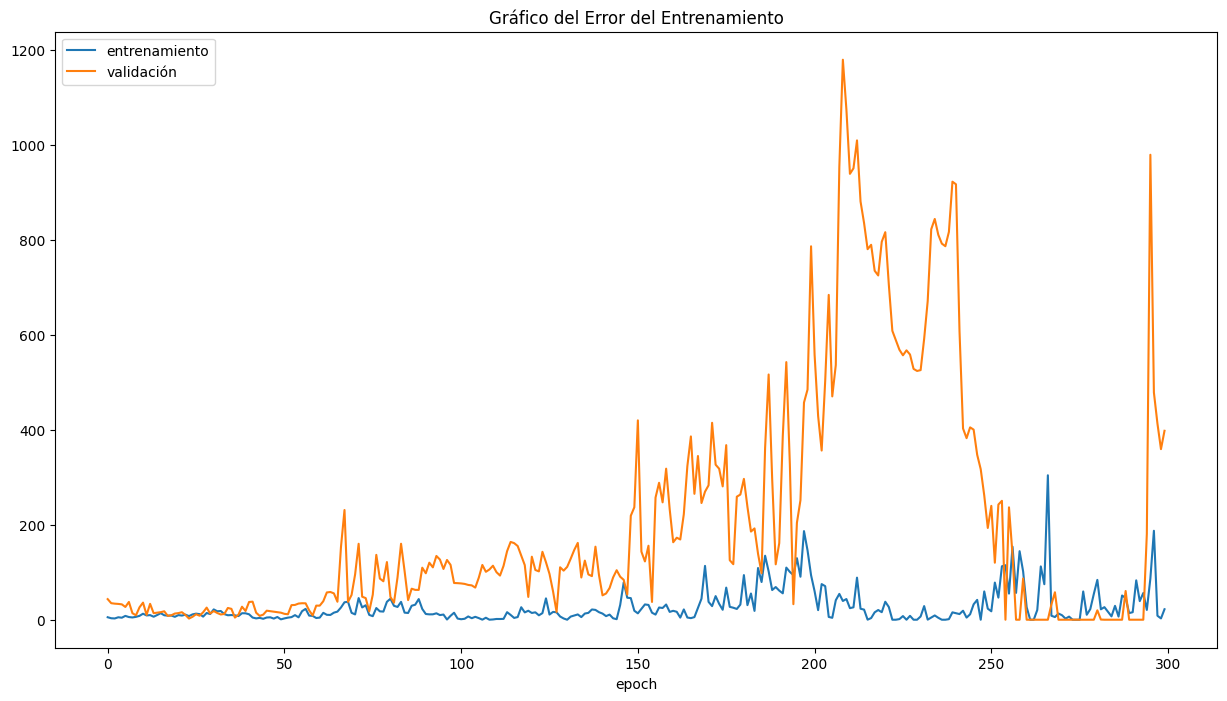

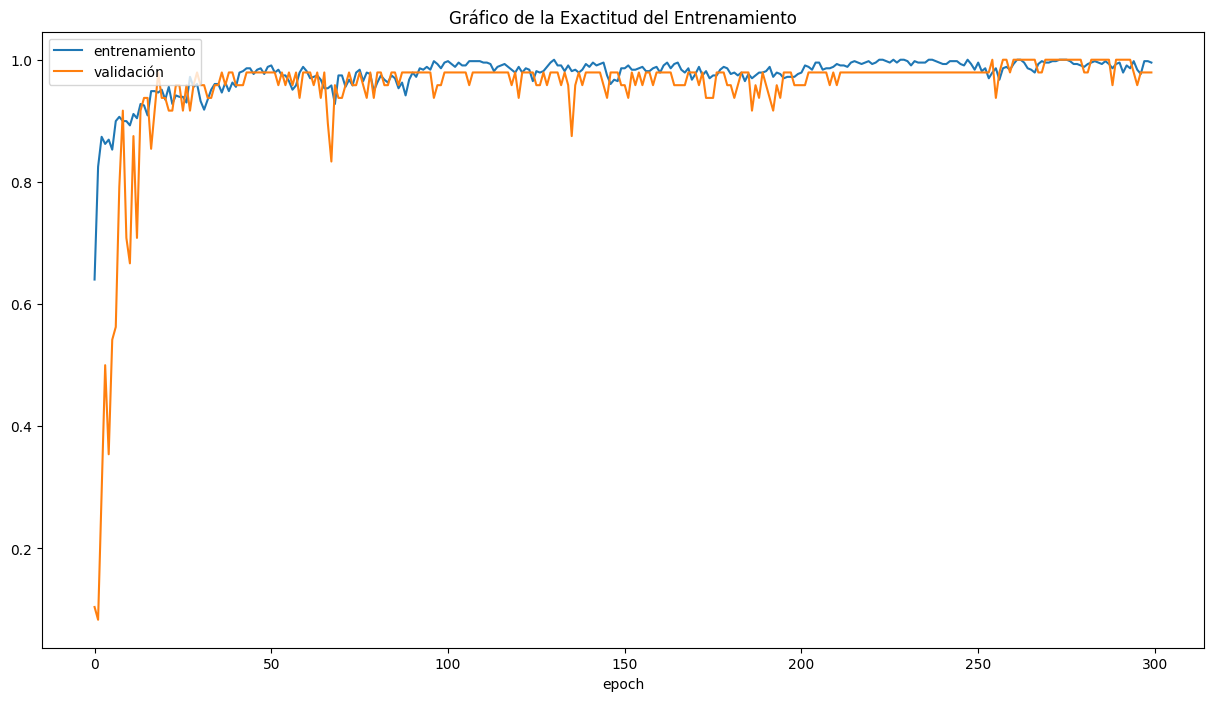

In [9]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [10]:
#@title Evaluar red entrenada con datos de entrenamiento


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, esDAimag, clases_map, rtdo="TODOS", cantMostrar="TODAS", claseFiltrar=None):

    # determina clase a filtrar
    if (claseFiltrar is None) or (claseFiltrar == "-"):
          clFiltrarID = None
          mostrarImagenes = False
    elif (claseFiltrar == "TODOS"):
          clFiltrarID = None
          mostrarImagenes = True
    else:
          clFiltrarID = dictMapeo[claseFiltrar]
          mostrarImagenes = True

    # determina tipo de resultado a mostrar
    if rtdo == "Clasificación Incorrecta":
      tipoRes = -1
    elif rtdo == "Clasificación Correcta":
      tipoRes = 1
    else:
      tipoRes = 0

    # determina cantidad a mostrar
    if (cantMostrar == "TODAS"):
      cantMostrar = len(x)
    elif (cantMostrar <= 0):
      cantMostrar = 0
      mostrarImagenes = False

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    # lista auxiliar para mostrar
    imgsParaMostrar = []

    # muestra los resultados con las imágenes
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                    idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA!"
        else:
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )
        resClasOK = (clReal==clPred)

        if mostrarImagenes:

          # determina si filtra por clase
          if (clFiltrarID is None) or (clFiltrarID == y[i]):

            # filtra por tipo de resultado
            if (tipoRes==0) or \
              ((tipoRes > 0) and resClasOK) or\
              ((tipoRes < 0) and not(resClasOK)):
                # el titulo par aponer en la imagen
                strTitulo = 'Real: ' + clReal + ' / Modelo: '
                strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'

                # agrega para mostrar
                imgsParaMostrar.append( [strTitulo, x[i] ] )


    # cierra la imagen
    if mostrarImagenes and (cantMostrar>0) and (len(imgsParaMostrar)>0):
      print("\n>Detalle: ")

      if cantMostrar >= len(imgsParaMostrar):
        # muestra todas
        eligeImAlAzar = False
        cantMostrar = len(imgsParaMostrar)
      else:
        # muestra al azar
        eligeImAlAzar = True

      # prepara para mostrar imagenes
      nCols = 3
      nRows = cantMostrar // nCols
      if (nRows*nCols) < cantMostrar:
        nRows = nRows + 1
      plt.figure(figsize=(10, 3*nRows))
      posImagen = 1

      for i in range(cantMostrar):
            # elige al azar o no para mostrar
            if eligeImAlAzar:
              posIm = random.randint(1, len(imgsParaMostrar))-1
            else:
              if i >= len(imgsParaMostrar):
                break
              else:
                posIm = i
            # determina datos a mostrar
            im = imgsParaMostrar[posIm][1]
            tit = imgsParaMostrar[posIm][0]

            # muestra la imagen
            ax = plt.subplot(nRows, nCols, posImagen)
            plot_image( im )
            plt.title( tit )
            posImagen = posImagen + 1

            # saca elemento de la lista para no elegirlo al azar de nuevo
            if eligeImAlAzar:
              if len(imgsParaMostrar) > posIm:
                imgsParaMostrar.pop( posIm )

      #plt.tight_layout()
      fig = plt.gcf()
      plt.show()
      plt.close(fig)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_map],
        columns=['m:{:}'.format(x) for x in clases_map]
      )
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")


# genera toda la interface para evaluar modeo DAE
def crearUI_evaluarModelo(clDefecto, clases, ruidoPorDefecto, funcionCambiaSeleccion):

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}

  # prepara combo para filtrar por clase
  seleccion_CLASES = ["-", "TODOS"]
  seleccion_CLASES.extend( clases )
  seleccion_CLASES.sort()
  combo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefecto,
      description = 'Filtrar por clase:',
      style=style_3D,
      disabled = False,
  )

  # prepara combo para filtrar por resultado
  selecc_resutado = [ "TODOS", "Clasificación Incorrecta", "Clasificación Correcta" ]
  combo_resultado = widgets.Dropdown(
      options = selecc_resutado,
      value = selecc_resutado[0],
      description = 'Filtrar por resultado:',
      style=style_3D,
      disabled = False,
  )

  # prepara combo para filtrar por cantidad
  selecc_cantidad = [ 3 ]
  selecc_cantidad.extend( range(6, 151, 9) )
  selecc_cantidad.append( "TODAS" )
  combo_cantidad = widgets.Dropdown(
      options = selecc_cantidad,
      value = 6,
      description = 'Mostrar N imágenes al azar:',
      style=style_3D,
      disabled = False,
  )

  prueba_ui = widgets.GridBox(children=[combo_clase, combo_resultado, combo_cantidad],
          layout=Layout(width='100%')
        )
  out_prueba = widgets.interactive_output(funcionCambiaSeleccion, {'cant':combo_cantidad, 'rtdo': combo_resultado,'cl':combo_clase})

  return prueba_ui, out_prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl):

    # prueba con los datos de entrenamiento
    print("\n\n*** Resultados con datos de Entrenamiento: ")
    probarModelo(x_train, y_train, esDAimag_train, clases_map, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(Dropdown(description='Filtrar por clase:', options=('-', '0', '1', '2', '3', '4', '5', '6', …

Output()

7) Evaluar el modelo de la RNA entrenado usando las imágenes de prueba:

In [11]:
#@title Evaluar red entrenada con datos de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl):

  # prueba con los datos de prueba
  print("\n\n*** Resultados con datos de Prueba: ")
  probarModelo(x_test, y_test, esDAimag_test, clases_map, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(Dropdown(description='Filtrar por clase:', options=('-', '0', '1', '2', '3', '4', '5', '6', …

Output()